<a href="https://colab.research.google.com/github/Jeetesh1512/learnML/blob/main/fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import Sequential, Model, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Dense, Input , Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [23]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train,Y_train), (X_test, y_test) = fashion_mnist.load_data()

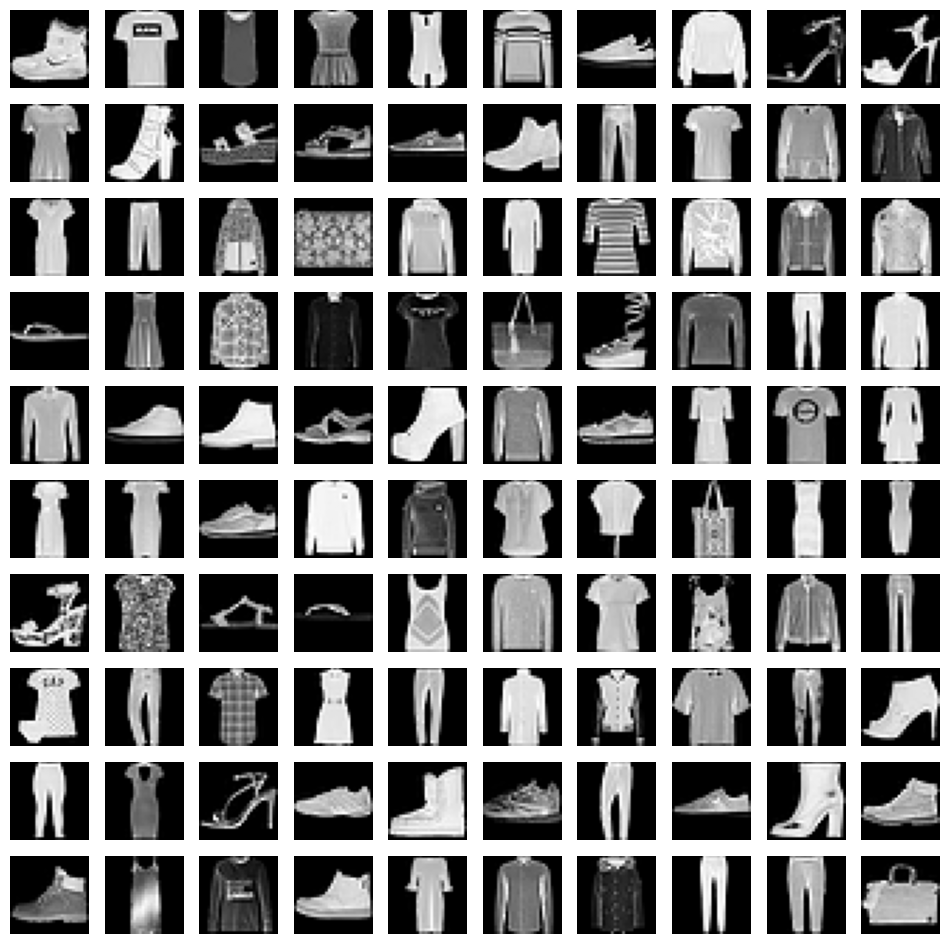

In [24]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(x_train[i],cmap='gray')

In [25]:
X_train,X_val,y_train,y_val = train_test_split(x_train,Y_train,test_size=0.2,random_state=42)

In [26]:
y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [27]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [28]:
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

print(X_train.shape, X_val.shape, X_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)


In [29]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)
(48000, 10) (12000, 10) (10000, 10)


In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range = 0.1,
    shear_range=0.1,
    horizontal_flip = True,
    vertical_flip=False
)
train_datagen.fit(X_train)

In [31]:
print(y_train.shape)
print(y_test.shape)

(48000, 10)
(10000, 10)


In [32]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Conv2D, Add, Activation, Concatenate, Lambda

def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    # ---- Channel Attention ----
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(feature_map)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(feature_map)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([feature_map, channel_attention])

    # ---- Spatial Attention ----
    avg_pool_spatial = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    concat = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [33]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense

IMG_ROWS, IMG_COLS = 28, 28
NUM_CLASSES = 10

inputs = Input(shape=(IMG_ROWS, IMG_COLS, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)


In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,29

 Total params: 289,514 (1.10 MB)

 Trainable params: 288,618 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [35]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-6)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

In [37]:
history = model.fit(
    train_datagen.flow(X_train,y_train,batch_size=32),
    validation_data = (X_val,y_val),
    epochs=130,
    verbose=1
)

Epoch 1/130


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.5819 - loss: 1.2475 - val_accuracy: 0.8133 - val_loss: 0.4914
Epoch 2/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7616 - loss: 0.6457 - val_accuracy: 0.8188 - val_loss: 0.4748
Epoch 3/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8027 - loss: 0.5399 - val_accuracy: 0.8300 - val_loss: 0.4446
Epoch 4/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.8213 - loss: 0.5004 - val_accuracy: 0.7857 - val_loss: 0.5103
Epoch 5/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8290 - loss: 0.4708 - val_accuracy: 0.8338 - val_loss: 0.4278
Epoch 6/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8403 - loss: 0.4431 - val_accuracy: 0.8666 - val_loss: 0.3446
Epoch 7/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8487 - loss: 0.4218 - val_accuracy: 0.8662 - val_loss: 0.3512
Epoch 8/130
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8542 - los

In [38]:
results = model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9161 - loss: 0.2357


In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9161 - loss: 0.2357
Test Loss: 0.2338
Test Accuracy: 91.70%


In [40]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

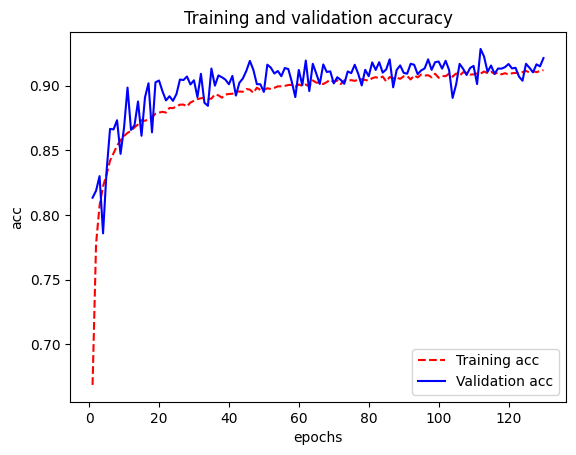

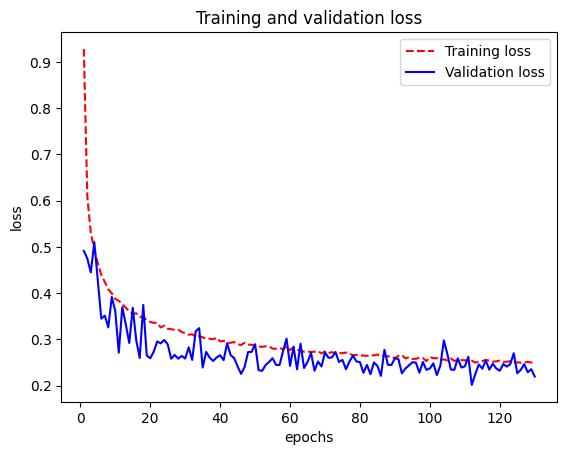

<Figure size 640x480 with 0 Axes>

In [41]:
plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Figure size 1200x1200 with 0 Axes>

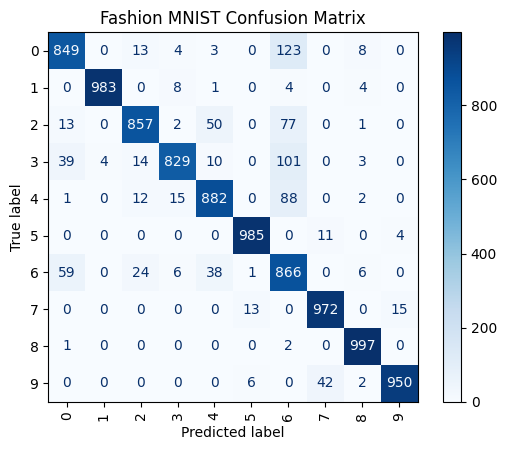

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(X_test)          # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)      # predicted class indices
y_true = np.argmax(y_test, axis=1)            # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(12,12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Fashion MNIST Confusion Matrix")
plt.show()
